Linear Cancellation ICR: 0.0853 dB
Linear cancellation results saved to linear_cancellation_output_1000.csv


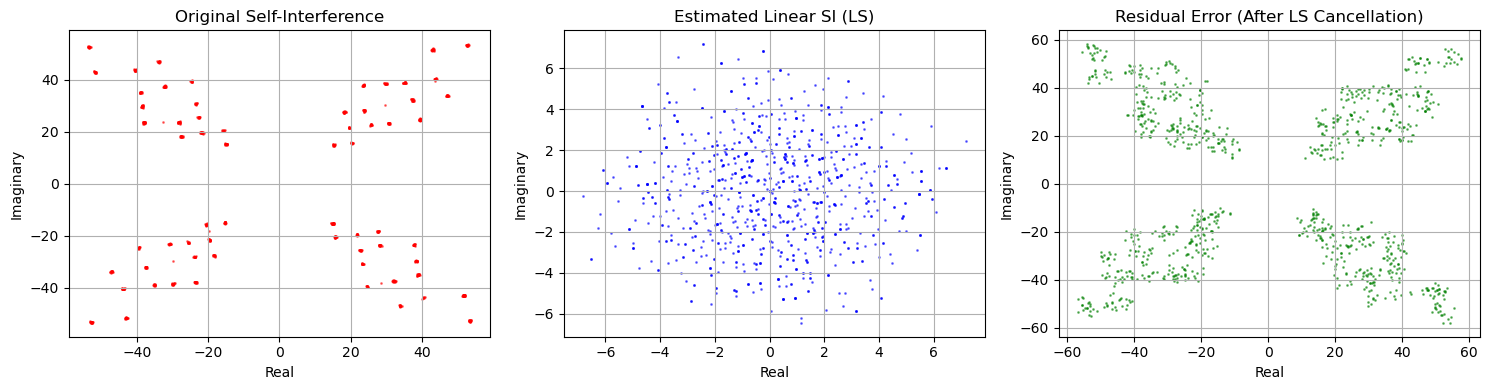

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#####################################################
# B. Linear Cancellation
#####################################################

def build_design_matrix_complex(x, L):
    """
    Construct the design matrix Uc for Least Squares estimation.
    Each row contains L past symbols (reversed order).
    """
    N = len(x)
    Uc = []
    for i in range(N - L + 1):
        row = x[i:i+L][::-1]
        Uc.append(row)
    return np.array(Uc)

def complex_matrix_to_real(Uc):
    """
    Convert a complex matrix (M, L) into a real matrix (2M, 2L).
    The transformation follows:
        [ A  -B ]
        [ B   A ]
    where A = real part, B = imaginary part.
    """
    M, L = Uc.shape
    A = Uc.real
    B = Uc.imag
    top = np.hstack((A, -B))
    bottom = np.hstack((B, A))
    U_real = np.vstack((top, bottom))
    return U_real

def complex_vector_to_real(vc):
    """
    Convert a complex vector (M,) into a real vector (2M,)
    by interleaving real and imaginary parts.
    """
    M = len(vc)
    out = np.zeros(2*M)
    out[0::2] = vc.real
    out[1::2] = vc.imag
    return out

def linear_cancellation(tx_signal, rx_signal, L):
    """
    Perform linear interference cancellation using Least Squares (LS).
    Returns:
    - y_lin_full: Estimated linear SI
    - error: Residual error after cancellation
    - h_complex: Estimated channel coefficients
    - icr_db: Interference Cancellation Ratio (ICR) in dB
    """
    N = len(tx_signal)

    # Construct Design Matrix
    Uc = build_design_matrix_complex(tx_signal, L)
    M = Uc.shape[0]
    y_target = rx_signal[L-1:]  # Align dimensions

    # Convert to real domain
    U_real = complex_matrix_to_real(Uc)
    y_real = complex_vector_to_real(y_target)

    # Solve Least Squares problem: U_real @ h_real ≈ y_real
    h_real, res, rank, s = np.linalg.lstsq(U_real, y_real, rcond=None)

    # Convert back to complex domain
    h_complex = h_real[:L] + 1j*h_real[L:]

    # Compute estimated SI
    y_lin_c = Uc @ h_complex
    y_lin_full = np.zeros(N, dtype=complex)
    y_lin_full[L-1:] = y_lin_c  # Align estimated SI

    # Compute error signal (residual interference)
    error = rx_signal - y_lin_full

    # Compute ICR
    num = np.sum(np.abs(rx_signal)**2)
    den = np.sum(np.abs(error)**2)
    icr_db = 10*np.log10(num/den)

    return y_lin_full, error, h_complex, icr_db

#####################################################
# Load Data and Apply Linear Cancellation
#####################################################

# Load the previously generated self-interference dataset
df = pd.read_csv("self_interference_data_1000.csv")

# Extract transmitted and received signal components
tx_signal = df['tx_real'].values + 1j * df['tx_imag'].values
rx_signal = df['si_real'].values + 1j * df['si_imag'].values

# Set filter length (L) for LS estimation
L = 5  # Can be adjusted to test different filter sizes

# Perform linear cancellation
y_lin_full, error, h_complex, icr_db = linear_cancellation(tx_signal, rx_signal, L)

print(f"Linear Cancellation ICR: {icr_db:.4f} dB")

# Save the processed results to CSV
output_df = pd.DataFrame({
    'tx_real': tx_signal.real,
    'tx_imag': tx_signal.imag,
    'si_real': rx_signal.real,
    'si_imag': rx_signal.imag,
    'si_est_real': y_lin_full.real,
    'si_est_imag': y_lin_full.imag,
    'residual_real': error.real,
    'residual_imag': error.imag
})
output_df.to_csv("linear_cancellation_output_1000.csv", index=False)

print("Linear cancellation results saved to linear_cancellation_output_1000.csv")

#####################################################
# Visualization of Results
#####################################################

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(rx_signal.real, rx_signal.imag, s=1, alpha=0.5, color='red')
plt.title("Original Self-Interference")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(y_lin_full.real, y_lin_full.imag, s=1, alpha=0.5, color='blue')
plt.title("Estimated Linear SI (LS)")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

plt.subplot(1,3,3)
plt.scatter(error.real, error.imag, s=1, alpha=0.5, color='green')
plt.title("Residual Error (After LS Cancellation)")
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.grid(True)

plt.tight_layout()
plt.show()
